# Using InSegt for volumetric segmentation

Here we show how to use InSegt for slice-wise segmentation. This is an extension of the notebook on Multiscale Gauss features segmentation of nerves. 


In [1]:
import insegtpy
import insegtpy.models
import urllib.request
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

## Load the volume
Load the volume from QIM 3D data repository. This might take half a minute or so, depending on your connectiton.

In [2]:
url = 'https://qim.compute.dtu.dk/data-repository/InSegt_data/3D/nerves_part.tiff'
print('Loading the volume...')

volfile = PIL.Image.open(urllib.request.urlopen(url))

h, w = np.shape(volfile)
vol = []

for i in range(volfile.n_frames):
    volfile.seek(i)
    vol.append(np.array(volfile))
vol = np.array(vol)

print(f'Volume shape is: {vol.shape}')
print(f'Volume data type is: {vol.dtype}')
print(f'Intensity range is: {vol.min()}-{vol.max()}')

Loading the volume...
Volume shape is: (1024, 350, 350)
Volume data type is: uint8
Intensity range is: 0-236


## Visualize a few slices from the volume
Show a few cross-sections of the volume. Also check the histogram.

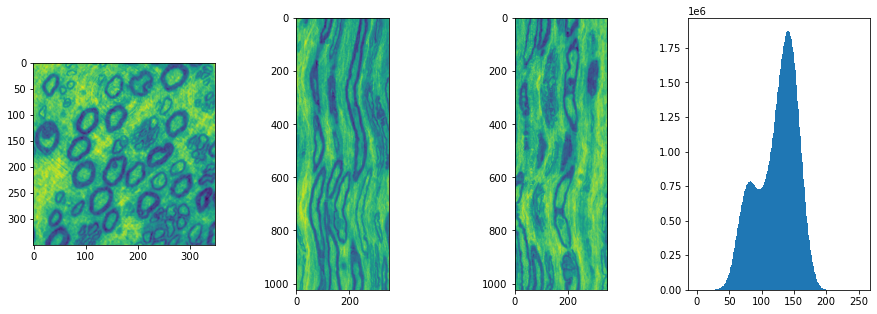

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(vol[512])
ax[1].imshow(vol[:, 175,:])
ax[2].imshow(vol[:, :, 175])
ax[3].hist(vol.ravel(),np.arange(257)-0.5)
plt.show()

## Build the model 
Build the model using one slice from the volume. This will extract and cluster features from the image. Here we use the slice with the index 0.

In [4]:
index = 0
model = insegtpy.models.gauss_features_segmentor(vol[index], 
                                   branching_factor = 25, 
                                   number_layers = 3,
                                   number_training_vectors = 40000,
                                   features_sigma = [1,2,4,8], 
                                   propagation_size = 9, 
                                   scales = [1, 0.5, 0.25])

Bulding multi-scale GaussFeatSegt model.
Number of images 1
Number of training patches 40000
Number of layers 3 number of elements 16275
Number of images 1
Number of training patches 30625
Number of layers 3 number of elements 16275
Number of images 1
Number of training patches 7569
Number of layers 2 number of elements 650


Train InSegt model by annotating the image. When you are sattisfied with the resulting segmentation, close the InSegt window. 

In [ ]:
ex = insegtpy.insegt(vol[index], model)

## Segment all slices from the volume
Use the trained model to segment all volume slices.

In [ ]:
seg = []
for v in tqdm.tqdm(vol):
    prob = model.new_image_to_prob(v)
    seg.append(insegtpy.utils.segment_probabilities(prob))
seg = np.array(seg)

## Visualize a few slices from the segmentation
Yay!

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(seg[512])
ax[1].imshow(seg[:, 175,:])
ax[2].imshow(seg[:, :, 175])
ax[3].hist(seg.ravel(),np.arange(5)-0.5)
plt.show()

In [ ]:
# import tifffile
# tifffile.imwrite('seg.tiff', (seg*50).astype(np.uint8))
# tifffile.imwrite('vol.tiff', vol)
# tifffile.imwrite('probs.tiff', (probs*255).astype(np.uint8))
